# Convolutional Autoencoder in Keras

this is merely a copy of the following excellent tutorial:
https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
# convolutional autoencoder in keras

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(1, 28, 28)) # 1ch=black&white, 28 x 28

x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img) #nb_filter, nb_row, nb_col
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

print "shape of encoded", K.int_shape(encoded)

Using Theano backend.


shape of encoded (None, 8, 4, 4)


Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5005)


In [2]:
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)

# In original tutorial, border_mode='same' was used. 
# then the shape of 'decoded' will be 32 x 32, instead of 28 x 28
# x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(x) 
x = Convolution2D(16, 3, 3, activation='relu', border_mode='valid')(x) 

x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 5, 5, activation='sigmoid', border_mode='same')(x)
print "shape of decoded", K.int_shape(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

shape of decoded (None, 1, 28, 28)


In [3]:
from keras.datasets import mnist 
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32')/255. # 0-1.に変換
x_test = x_test.astype('float32')/255. 

x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

print x_train.shape

(60000, 1, 28, 28)


In [4]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train, nb_epoch=50, batch_size=128,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)
#               callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
### if you use TensorFlow backend, you can set TensorBoard callback

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s - loss: 0.2295 - val_loss: 0.1752
Epoch 2/50
60000/60000 [==============================] - 9s - loss: 0.1635 - val_loss: 0.1516
Epoch 3/50
60000/60000 [==============================] - 9s - loss: 0.1465 - val_loss: 0.1370
Epoch 4/50
60000/60000 [==============================] - 9s - loss: 0.1363 - val_loss: 0.1313
Epoch 5/50
60000/60000 [==============================] - 9s - loss: 0.1293 - val_loss: 0.1254
Epoch 6/50
60000/60000 [==============================] - 9s - loss: 0.1243 - val_loss: 0.1211
Epoch 7/50
60000/60000 [==============================] - 9s - loss: 0.1209 - val_loss: 0.1170
Epoch 8/50
60000/60000 [==============================] - 9s - loss: 0.1183 - val_loss: 0.1152
Epoch 9/50
60000/60000 [==============================] - 9s - loss: 0.1162 - val_loss: 0.1147
Epoch 10/50
60000/60000 [==============================] - 10s - loss: 0.1149 - val_loss: 0.112

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# utility function for showing images
def show_imgs(x_test, decoded_imgs=None, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

input (upper row)
decoded (bottom row)


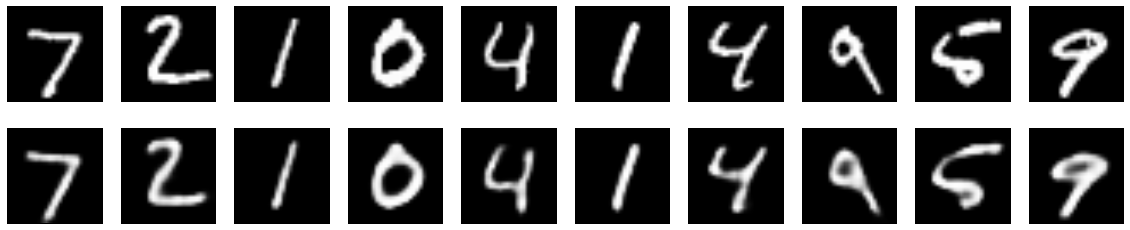

In [8]:
decoded_imgs = autoencoder.predict(x_test)
print "input (upper row)\ndecoded (bottom row)"
show_imgs(x_test, decoded_imgs)

# Denoising autoencoder

Train a denoising autoencoder by adding random noise before training!

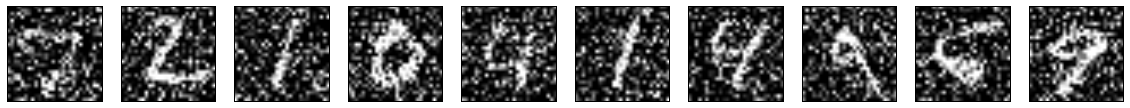

In [9]:
# Add random noise before training!
noise_factor = 0.5 
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

show_imgs(x_test_noisy)

In [10]:
# it takes more epochs to converge
autoencoder.fit(x_train_noisy, x_train, nb_epoch=100, batch_size=128,
                shuffle=True, validation_data=(x_test_noisy, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 9s - loss: 0.1444 - val_loss: 0.1339
Epoch 2/100
60000/60000 [==============================] - 8s - loss: 0.1340 - val_loss: 0.1300
Epoch 3/100
60000/60000 [==============================] - 8s - loss: 0.1316 - val_loss: 0.1288
Epoch 4/100
60000/60000 [==============================] - 8s - loss: 0.1302 - val_loss: 0.1272
Epoch 5/100
60000/60000 [==============================] - 8s - loss: 0.1291 - val_loss: 0.1278
Epoch 6/100
60000/60000 [==============================] - 8s - loss: 0.1284 - val_loss: 0.1270
Epoch 7/100
60000/60000 [==============================] - 8s - loss: 0.1275 - val_loss: 0.1259
Epoch 8/100
60000/60000 [==============================] - 8s - loss: 0.1269 - val_loss: 0.1275
Epoch 9/100
60000/60000 [==============================] - 8s - loss: 0.1264 - val_loss: 0.1260
Epoch 10/100
60000/60000 [==============================] - 8s - loss: 0.1258 - val_lo

denoising


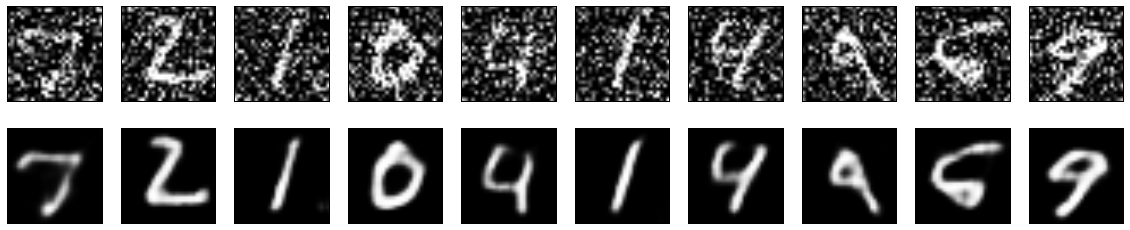


of course, it works with original noise-less images


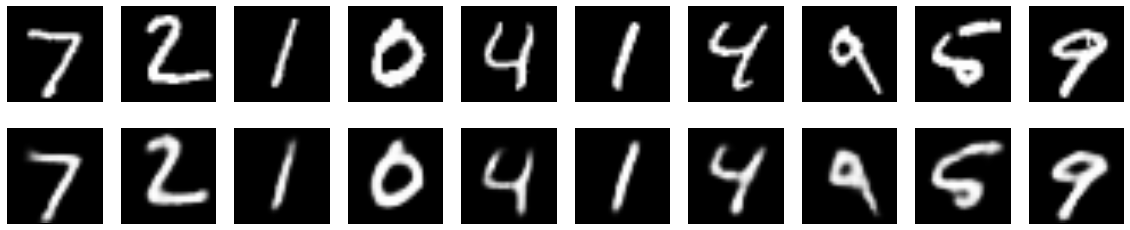

In [12]:
# denoising
print "denoising"
decoded_imgs = autoencoder.predict(x_test_noisy)
show_imgs(x_test_noisy, decoded_imgs)

# what if we feed the original noise-free test images?
print "\nof course, it works with original noise-less images"
decoded_imgs = autoencoder.predict(x_test)
show_imgs(x_test, decoded_imgs) # yes, it works well without noise!

training history


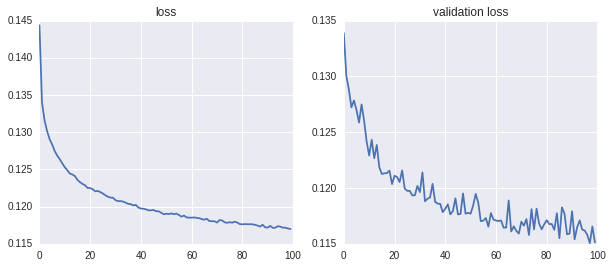

In [31]:
print "Training history"
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(autoencoder.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(autoencoder.history.history['val_loss'])
ax2.set_title('validation loss')